# LiVU cohort with pulled demographics

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import os
import glob
from os import path
import numpy as np
from datetime import datetime, timedelta
import matplotlib
import glob

### LIVU All
Run nodule detection on all scans

In [2]:
a = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans.csv"
a = pd.read_csv(a)
a

,id
0,8964715287time20171208
1,29045108928time20160406
2,7636455313time20170904
3,4521805785time20171117
4,34156084363time20180709
...,...
4105,35802034477time20181212
4106,34317064156time20170126
4107,16511194870time20180419
4108,3775151383time20181102


In [3]:
root_dir = "/home/local/VANDERBILT/litz/data/livu/DeepLungScreening/nifti"
rows = []
for fname in os.listdir(root_dir):
    rows.append({'id':fname.split('.nii.gz')[0]})
allscans = pd.DataFrame(rows)

# split into 3 jobs for faster processing
for i, job in enumerate([allscans.iloc[:1370], allscans.iloc[1370:1370*2], allscans.iloc[1370*2:]]):
    allscans_path = f"/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job{i}.csv"
    job.to_csv(allscans_path, index=False)

In [4]:
path1 = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job0.csv"
path2 = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job1.csv"
path3 = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job2.csv"
job1 = pd.read_csv(path1)
job2 = pd.read_csv(path2)
job3 = pd.read_csv(path3)
job3.merge(job1, on='id')

,id


In [5]:
root_dir = "/home/local/VANDERBILT/litz/data/livu/DeepLungScreening/prep"
all_prepscans_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_prep.csv"
rows = []
for fpath in glob.glob(os.path.join(root_dir, "*_clean.npy")):
    rows.append({'id':os.path.basename(fpath).split('_clean.npy')[0]})
all_prepscans = pd.DataFrame(rows)
all_prepscans.to_csv(all_prepscans_path, index=False)

### LIVU cohort

In [6]:
# Prepped scans
prep_dir = "/home/local/VANDERBILT/litz/data/livu/DeepLungScreening/prep"
rows = []
for p in glob.glob(os.path.join(prep_dir, "*_clean.nii.gz")):
    scanid = os.path.basename(p).split('_clean.nii.gz')[0]
    mcl, date = scanid.split('time')
    scan_date = datetime.strptime(date, "%Y%m%d")
    rows.append({'mcl_id': mcl, 'scan_date': scan_date, 'id': scanid})

scan_df = pd.DataFrame(rows)
scan_df = scan_df.sort_values(by=['mcl_id', 'scan_date'])
scan_df['scan_order'] = scan_df.groupby(['mcl_id'])['scan_date'].rank('dense', ascending=True) # assign a T0, T1, or T2 for each scan
scan_df['scan_order'] = scan_df['scan_order'] - 1
scan_df['scan_order'] = scan_df['scan_order'].astype(int)
scan_df

,mcl_id,scan_date,id,scan_order
2214,10045095103,2017-01-30,10045095103time20170130,0
1914,10065357317,2017-05-05,10065357317time20170505,0
1157,10089624560,2018-11-22,10089624560time20181122,0
3452,10089624560,2019-01-03,10089624560time20190103,1
933,10089684335,2015-06-16,10089684335time20150616,0
...,...,...,...,...
2940,9927103076,2018-05-17,9927103076time20180517,0
404,9927103076,2019-03-16,9927103076time20190316,1
2310,9951807921,2016-03-15,9951807921time20160315,0
814,9978249933,2017-06-03,9978249933time20170603,0


In [7]:
SPN = False
if SPN:
    scan_path = "/home/local/VANDERBILT/litz/data/livu/livu_spn_cohort_v2.csv"
    out_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_spn_prep_v2.csv"
else:
    scan_path = "/home/local/VANDERBILT/litz/data/livu/livu_nospn_cohort_v2.csv"
    out_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_nospn_prep_v2.csv"
scans = pd.read_csv(scan_path, dtype={'mcl_id': str})

scans['scan_date'] = pd.to_datetime(scans['scan_date'], format='%Y-%m-%d')
scans['lc_date'] = pd.to_datetime(scans['lc_date'], format='%Y-%m-%d')
scans['spn_date'] = pd.to_datetime(scans['spn_date'], format='%Y-%m-%d')
prep = scans.merge(scan_df, on=['mcl_id', 'scan_date', 'scan_order', 'id'])
print(f"num scans: {len(prep)}")
print(f"num subjects: {len(prep['mcl_id'].unique())}")
prep

num scans: 1175
num subjects: 480


,mcl_id,scan_order,scan_date,lc_code,lc_date,scan_label,lung_cancer,spn_date,id,bmi,age,sex,race
0,4715449525,0,2016-06-08,162,2016-01-26,4,1,NaT,4715449525time20160608,24.64,57.0,1.0,1.0
1,4715449525,1,2016-08-29,162,2016-01-26,4,1,NaT,4715449525time20160829,24.64,57.0,1.0,1.0
2,4715449525,2,2016-11-02,162,2016-01-26,4,1,NaT,4715449525time20161102,24.64,57.0,1.0,1.0
3,27234772794,0,2015-07-09,162.9,2014-04-17,4,1,NaT,27234772794time20150709,19.32,63.0,0.0,1.0
4,27234772794,1,2016-02-11,162.9,2014-04-17,4,1,NaT,27234772794time20160211,19.32,63.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,3899477402,0,2018-02-17,NaN,NaT,5,0,2014-09-29,3899477402time20180217,18.57,72.0,1.0,2.0
1171,3899477402,1,2018-08-21,NaN,NaT,5,0,2014-09-29,3899477402time20180821,18.57,72.0,1.0,2.0
1172,3899477402,2,2018-11-25,NaN,NaT,5,0,2014-09-29,3899477402time20181125,18.57,72.0,1.0,2.0
1173,3899477402,3,2019-01-03,NaN,NaT,5,0,2014-09-29,3899477402time20190103,18.57,72.0,1.0,2.0


### Cross sectional cohort

In [9]:
# for cases, only scans before diagnosis are usable
usable_cases = prep[(prep['lung_cancer']==1) & (prep['scan_label']<=3)]
controls = prep[prep['lung_cancer']==0]
usable_cohort = pd.concat([usable_cases, controls])
usable_cohort['lung_cancer'].value_counts()

0    405
1     76
Name: lung_cancer, dtype: int64

In [62]:
cs = usable_cohort.loc[usable_cohort.groupby('mcl_id')['scan_date'].idxmax()]
cs_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_prep_cs.csv"
cs = cs.rename(columns={'mcl_id':'pid', 'scan_order':'session'})
cs.to_csv(cs_path, index=False)

In [63]:
cs['lung_cancer'].value_counts()


0    169
1     58
Name: lung_cancer, dtype: int64

### Longitudinal cohort with variable scans

In [12]:
# for cases, only scans before diagnosis are usable
usable_cases = prep[(prep['lung_cancer']==1) & (prep['scan_label']<=3)]
controls = prep[prep['lung_cancer']==0]
usable_cohort = pd.concat([usable_cases, controls])
longall = usable_cohort.rename(columns={'mcl_id':'pid', 'scan_order':'session'})
longall.to_csv("/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_nospn_prep_allscan.csv")

### Lognitudinal cohort

0    112
1     15
Name: lung_cancer, dtype: int64


,mcl_id,scan_order,scan_date,lc_code,lc_date,scan_label,lung_cancer,spn_date,id,bmi,age,sex,race,latest_scan_date,Duration
157,10173723090,2,2018-01-11,NaN,NaT,5,0,2013-01-01,10173723090time20180111,25.08,43.0,1.0,2.0,2018-01-11,0
156,10173723090,1,2016-12-11,NaN,NaT,5,0,2013-01-01,10173723090time20161211,25.08,43.0,1.0,2.0,2018-01-11,396
42,10694859066,1,2018-11-30,NaN,NaT,5,0,2012-05-02,10694859066time20181130,25.34,55.0,1.0,1.0,2018-11-30,0
41,10694859066,0,2018-04-24,NaN,NaT,5,0,2012-05-02,10694859066time20180424,25.34,55.0,1.0,1.0,2018-11-30,220
217,11262900643,1,2018-11-19,NaN,NaT,3,0,2019-06-24,11262900643time20181119,33.36,66.0,0.0,1.0,2018-11-19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,9677707064,1,2018-11-16,NaN,NaT,3,0,2019-05-30,9677707064time20181116,41.26,30.0,1.0,1.0,2019-05-31,196
146,9801573604,1,2017-01-31,NaN,NaT,5,0,2012-10-17,9801573604time20170131,30.62,58.0,1.0,1.0,2017-01-31,0
145,9801573604,0,2016-05-24,NaN,NaT,5,0,2012-10-17,9801573604time20160524,30.62,58.0,1.0,1.0,2017-01-31,252
99,9895940092,1,2017-01-27,NaN,NaT,2,0,2018-01-29,9895940092time20170127,34.72,55.0,1.0,1.0,2017-01-27,0


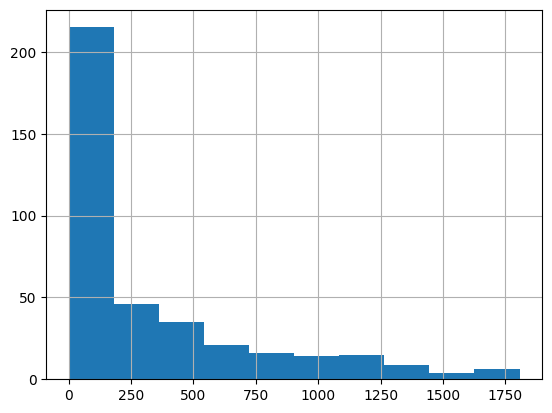

In [5]:
# subjects with at least 2 scans
long = usable_cohort[~usable_cohort['id'].isnull()]
long_pids = long.groupby('mcl_id', as_index=False)['id'].count()
long_pids = long_pids[long_pids['id']>1]
long = long.merge(long_pids['mcl_id'], on='mcl_id')

# num subjects w/ longitudinal img per cohort
a = long.groupby('mcl_id').max()
print(a['lung_cancer'].value_counts())

# compute relative time distance between each scan
max_date = long.groupby('mcl_id', as_index=False)['scan_date'].max()
max_date = max_date.rename(columns={'scan_date': 'latest_scan_date'})
long = long.merge(max_date, on='mcl_id')
long['Duration'] = long['latest_scan_date'] - long['scan_date']
long['Duration'] = long['Duration'].apply(lambda x: x.days)

long['Duration'].hist()
# get 2 latest scan per subject
two_scan = long.loc[long.groupby('mcl_id')['scan_order'].nlargest(2).index.get_level_values(1)]
two_scan

In [7]:
two_scan_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_nospn_prep_twoscan_v2.csv"
two_scan = two_scan.rename(columns={'mcl_id':'pid', 'scan_order':'session'})
two_scan['filename'] = two_scan['id'].apply(lambda x: f"{x}.nii.gz")
two_scan.to_csv(two_scan_path, index=False)

In [9]:
two_scan

,pid,session,scan_date,lc_code,lc_date,scan_label,lung_cancer,spn_date,id,bmi,age,sex,race,latest_scan_date,Duration,filename
157,10173723090,2,2018-01-11,NaN,NaT,5,0,2013-01-01,10173723090time20180111,25.08,43.0,1.0,2.0,2018-01-11,0,10173723090time20180111.nii.gz
156,10173723090,1,2016-12-11,NaN,NaT,5,0,2013-01-01,10173723090time20161211,25.08,43.0,1.0,2.0,2018-01-11,396,10173723090time20161211.nii.gz
42,10694859066,1,2018-11-30,NaN,NaT,5,0,2012-05-02,10694859066time20181130,25.34,55.0,1.0,1.0,2018-11-30,0,10694859066time20181130.nii.gz
41,10694859066,0,2018-04-24,NaN,NaT,5,0,2012-05-02,10694859066time20180424,25.34,55.0,1.0,1.0,2018-11-30,220,10694859066time20180424.nii.gz
217,11262900643,1,2018-11-19,NaN,NaT,3,0,2019-06-24,11262900643time20181119,33.36,66.0,0.0,1.0,2018-11-19,0,11262900643time20181119.nii.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,9677707064,1,2018-11-16,NaN,NaT,3,0,2019-05-30,9677707064time20181116,41.26,30.0,1.0,1.0,2019-05-31,196,9677707064time20181116.nii.gz
146,9801573604,1,2017-01-31,NaN,NaT,5,0,2012-10-17,9801573604time20170131,30.62,58.0,1.0,1.0,2017-01-31,0,9801573604time20170131.nii.gz
145,9801573604,0,2016-05-24,NaN,NaT,5,0,2012-10-17,9801573604time20160524,30.62,58.0,1.0,1.0,2017-01-31,252,9801573604time20160524.nii.gz
99,9895940092,1,2017-01-27,NaN,NaT,2,0,2018-01-29,9895940092time20170127,34.72,55.0,1.0,1.0,2017-01-27,0,9895940092time20170127.nii.gz
